In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from hierarchicalforecast.core import HierarchicalReconciliation
from hierarchicalforecast.evaluation import HierarchicalEvaluation
from hierarchicalforecast.methods import BottomUp, TopDown, MinTrace
from sklearn.metrics import mean_squared_error, mean_absolute_error
import holidays
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
import pickle
import itertools

sns.set_theme(style="darkgrid")

load = pd.read_csv('data/load.csv')

c:\Users\louis\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data preprocessing

In [2]:
load_df = pd.read_csv('data/load.csv')
hierarchy_df = pd.read_csv("data/hierarchy.csv")
humidity_df = pd.read_csv("data/relative humidity.csv")
temperature_df = pd.read_csv("data/temperature.csv")

In [3]:
def df_formatting(load_df, hierarchy_df, humidity_df, temperature_df):
    load_df = pd.melt(load_df, id_vars=["meter_id", "date"], value_vars=load_df.columns.difference(["meter_id", "date"]),
                                var_name="hour", value_name="load")
    load_df["hour"] = load_df["hour"].str.strip("h").astype(int) - 1
    load_df["timestamp"] = pd.to_datetime(load_df["date"] + " " + load_df["hour"].astype(str) + ":00:00", format="%m/%d/%Y %H:%M:%S")
    load_df["meter_id"] = load_df["meter_id"].astype(int)
    load_df = load_df.drop(columns=["date", "hour"])
    # Remove meter ids that appear in training but not in test and conversely
    aggregate_list = [('max_timestamp', 'max'), ('min_timestamp', 'min')]
    meters_df = load_df.groupby("meter_id")["timestamp"].agg(aggregate_list).reset_index()
    excluded_meters_df = meters_df[(meters_df["max_timestamp"]<dt.datetime(2011,1,1)) | (meters_df["min_timestamp"]>dt.datetime(2011,1,1))]
    excluded_meters = excluded_meters_df["meter_id"].to_list() + [236]
    load_df = load_df[~load_df["meter_id"].isin(excluded_meters)]
    # Ensure that all training points are present, being possibly 0
    date_rng = pd.date_range(start='2005-01-01', end='2010-12-31 23:00:00', freq='1H')
    all_combinations = pd.MultiIndex.from_product([load_df['meter_id'].unique(), date_rng], names=['meter_id', 'timestamp'])
    df_all_combinations = pd.DataFrame(index=all_combinations).reset_index()
    df_filled = pd.merge(df_all_combinations, load_df, on=['meter_id', 'timestamp'], how='left', suffixes=('_orig', '')).fillna(0)
    df_filled = pd.concat([df_filled, load_df[load_df["timestamp"]>=dt.datetime(2011,1,1)]])
    df_filled = df_filled.sort_values(by=["meter_id", "timestamp"]).reset_index(drop=True)
    data_df = df_filled.merge(hierarchy_df, on="meter_id", how="left")
    data_df[hierarchy_df.columns.difference(["meter_id"])] = data_df[hierarchy_df.columns.difference(["meter_id"])].astype(str)

    humidity_df["timestamp"] = pd.to_datetime(humidity_df["date"] + " " + (humidity_df["hr"] - 1).astype(str) + ":00:00", format="%d%b%Y %H:%M:%S")
    temperature_df["timestamp"] = pd.to_datetime(temperature_df["date"] + " " + (temperature_df["hr"] - 1).astype(str) + ":00:00", format="%d%b%Y %H:%M:%S")
    humidity_df = humidity_df.drop(columns=["date", "hr"])
    temperature_df = temperature_df.drop(columns=["date", "hr"])
    #temperature_df["avg_temperature"] = temperature_df.filter(like="t_").mean(axis=1)
    #humidity_df["avg_humidity"] = humidity_df.filter(like="rh_").mean(axis=1)
    #temperature_df = temperature_df[["timestamp", "avg_temperature"]]
    #humidity_df = humidity_df[["timestamp", "avg_humidity"]]
    data_df = data_df.merge(humidity_df, on="timestamp", how="left")
    data_df = data_df.merge(temperature_df, on="timestamp", how="left")
    return data_df

joined_data_df = df_formatting(load_df, hierarchy_df, humidity_df, temperature_df)

In [4]:
def get_datasets(df):
  aggregation_dict = {"load": "sum"}
  aggregation_dict.update({col: "first" for col in df.columns if col not in ["load", "timestamp"]})
  top_level_df = df.groupby("timestamp").agg(aggregation_dict).reset_index()
  top_level_df = top_level_df.drop(columns=["meter_id", "aggregate", "mid_level"])
  aggregate_level_names = pd.unique(df["aggregate"])
  aggregate_levels = {}
  for agg_level in aggregate_level_names:
    agg_level_df = df[df["aggregate"] == agg_level].copy()
    agg_level_df = agg_level_df.groupby("timestamp").agg(aggregation_dict).reset_index()
    agg_level_df = agg_level_df.drop(columns=["meter_id", "aggregate", "mid_level"])
    aggregate_levels[agg_level] = agg_level_df
  mid_level_names = pd.unique(df["mid_level"])
  mid_levels = {}
  for mid_level in mid_level_names:
    mid_level_df = df[df["mid_level"] == mid_level].copy()
    mid_level_df = mid_level_df.copy().groupby("timestamp").agg(aggregation_dict).reset_index()
    mid_level_df = mid_level_df.drop(columns=["meter_id", "aggregate", "mid_level"])
    mid_levels[mid_level] = mid_level_df
  bottom_level_names = pd.unique(df["meter_id"])
  bottom_levels = {}
  for bottom_level in bottom_level_names:
    bottom_level_df = df[df["meter_id"] == bottom_level].copy()
    bottom_level_df = bottom_level_df.copy().groupby("timestamp").agg(aggregation_dict).reset_index()
    bottom_level_df = bottom_level_df.drop(columns=["meter_id", "aggregate", "mid_level"])
    bottom_levels[bottom_level] = bottom_level_df
  
  return top_level_df, aggregate_levels, mid_levels, bottom_levels

In [5]:
top_level_df, aggregate_levels, mid_levels, bottom_levels = get_datasets(joined_data_df)

In [6]:
def train_test_split(df):
    train_df = df[df["timestamp"].dt.year < 2011].fillna(0)
    test_df = df[df["timestamp"].dt.year == 2011].dropna()
    return train_df, test_df
top_level_train, top_level_test = train_test_split(top_level_df)
aggregate_train = {}
aggregate_test = {}
mid_levels_train = {}
mid_levels_test = {}
bottom_levels_train = {}
bottom_levels_test = {}
for agg in aggregate_levels.keys():
  train_df, test_df = train_test_split(aggregate_levels[agg])
  aggregate_train[agg] = train_df
  aggregate_test[agg] = test_df
for mid_level in mid_levels.keys():
  train_df, test_df = train_test_split(mid_levels[mid_level])
  mid_levels_train[mid_level] = train_df
  mid_levels_test[mid_level] = test_df
for bottom_level in bottom_levels.keys():
  train_df, test_df = train_test_split(bottom_levels[bottom_level])
  bottom_levels_train[bottom_level] = train_df
  bottom_levels_test[bottom_level] = test_df

# Fit a prophet model

In [7]:
holidays_MA = holidays.US(years=range(2005, 2012), state="MA")
holidays_df = pd.DataFrame(list(holidays_MA.items()), columns=['ds', 'holiday'])

In [9]:
# fit prophet model
m  = Prophet(holidays=holidays_df, changepoint_prior_scale=0.5, seasonality_prior_scale=1.0, daily_seasonality=False)


train_df = top_level_train.rename(columns={'timestamp': 'ds', 'load': 'y'})
summer_months = [6, 7, 8]
winter_months = [12, 1, 2]
interseason_months = [3, 4, 5, 9, 10, 11]
train_df["summer"] = train_df["ds"].dt.month.isin(summer_months)
train_df["winter"] = train_df["ds"].dt.month.isin(winter_months)
train_df["interseason"] = train_df["ds"].dt.month.isin(interseason_months)

m.add_seasonality(name='daily_summer', period=1, fourier_order=3, condition_name='summer')
m.add_seasonality(name='daily_winter', period=1, fourier_order=3, condition_name='winter')
m.add_seasonality(name='daily_interseason', period=1, fourier_order=3, condition_name='interseason')

for col in train_df.columns:
    if col not in ["ds", "y", "summer", "winter", "interseason"]:
        m.add_regressor(col)
m.fit(train_df)

with open('models/prophet/top_model.pkl', 'wb') as model_file:
    pickle.dump(m, model_file)

10:11:25 - cmdstanpy - INFO - Chain [1] start processing
10:15:24 - cmdstanpy - INFO - Chain [1] done processing


In [ ]:
for agg in aggregate_train.keys():
    agg_m  = Prophet(holidays=holidays_df, changepoint_prior_scale=0.5, seasonality_prior_scale=1.0, daily_seasonality=False)

    train_df = aggregate_train[agg].rename(columns={'timestamp': 'ds', 'load': 'y'})
    summer_months = [6, 7, 8]
    winter_months = [12, 1, 2]
    interseason_months = [3, 4, 5, 9, 10, 11]
    train_df["summer"] = train_df["ds"].dt.month.isin(summer_months)
    train_df["winter"] = train_df["ds"].dt.month.isin(winter_months)
    train_df["interseason"] = train_df["ds"].dt.month.isin(interseason_months)

    agg_m.add_seasonality(name='daily_summer', period=1, fourier_order=3, condition_name='summer')
    agg_m.add_seasonality(name='daily_winter', period=1, fourier_order=3, condition_name='winter')
    agg_m.add_seasonality(name='daily_interseason', period=1, fourier_order=3, condition_name='interseason')

    for col in train_df.columns:
        if col not in ["ds", "y", "summer", "winter", "interseason"]:
            agg_m.add_regressor(col)
    agg_m.fit(train_df)
    with open('models/prophet/agg_model_'+ agg +'.pkl', 'wb') as model_file:
        pickle.dump(agg_m, model_file)

for mid in mid_levels_train.keys():
    mid_m  = Prophet(holidays=holidays_df, changepoint_prior_scale=0.5, seasonality_prior_scale=1.0, daily_seasonality=False)

    train_df = mid_levels_train[mid].rename(columns={'timestamp': 'ds', 'load': 'y'})
    summer_months = [6, 7, 8]
    winter_months = [12, 1, 2]
    interseason_months = [3, 4, 5, 9, 10, 11]
    train_df["summer"] = train_df["ds"].dt.month.isin(summer_months)
    train_df["winter"] = train_df["ds"].dt.month.isin(winter_months)
    train_df["interseason"] = train_df["ds"].dt.month.isin(interseason_months)

    mid_m.add_seasonality(name='daily_summer', period=1, fourier_order=3, condition_name='summer')
    mid_m.add_seasonality(name='daily_winter', period=1, fourier_order=3, condition_name='winter')
    mid_m.add_seasonality(name='daily_interseason', period=1, fourier_order=3, condition_name='interseason')

    for col in train_df.columns:
        if col not in ["ds", "y", "summer", "winter", "interseason"]:
            mid_m.add_regressor(col)
    mid_m.fit(train_df)
    with open('models/prophet/mid_model_'+ mid +'.pkl', 'wb') as model_file:
        pickle.dump(mid_m, model_file)



In [ ]:
for bottom in bottom_levels_train.keys():
    bottom_m  = Prophet(holidays=holidays_df, changepoint_prior_scale=0.5, seasonality_prior_scale=1.0, daily_seasonality=False)

    train_df = bottom_levels_train[bottom].rename(columns={'timestamp': 'ds', 'load': 'y'})
    summer_months = [6, 7, 8]
    winter_months = [12, 1, 2]
    interseason_months = [3, 4, 5, 9, 10, 11]
    train_df["summer"] = train_df["ds"].dt.month.isin(summer_months)
    train_df["winter"] = train_df["ds"].dt.month.isin(winter_months)
    train_df["interseason"] = train_df["ds"].dt.month.isin(interseason_months)

    bottom_m.add_seasonality(name='daily_summer', period=1, fourier_order=3, condition_name='summer')
    bottom_m.add_seasonality(name='daily_winter', period=1, fourier_order=3, condition_name='winter')
    bottom_m.add_seasonality(name='daily_interseason', period=1, fourier_order=3, condition_name='interseason')

    for col in train_df.columns:
        if col not in ["ds", "y", "summer", "winter", "interseason"]:
            bottom_m.add_regressor(col)
    bottom_m.fit(train_df)
    with open('models/prophet/bottom_model_'+ bottom +'.pkl', 'wb') as model_file:
        pickle.dump(bottom_m, model_file)

NameError: name 'bottom_levels_train' is not defined

In [10]:
# Encode the hierarchy information
meter_ids = pd.unique(joined_data_df["meter_id"])
mid_level_ids = pd.unique(joined_data_df["mid_level"])
aggregate_level_ids = pd.unique(joined_data_df["aggregate"])
n_series = 1 + len(aggregate_level_ids) + len(mid_level_ids) + len(meter_ids)
S = np.zeros((n_series, len(meter_ids)))
hierarchy_df = pd.read_csv("data/hierarchy.csv")
hierarchy_df = hierarchy_df[hierarchy_df["meter_id"].isin(meter_ids)]
hierarchy_df["indicator"] = 1
aggregate_indicators = hierarchy_df.pivot_table(index="aggregate", columns="meter_id", values="indicator", fill_value=0)
mid_level_indicators = hierarchy_df.pivot_table(index="mid_level", columns="meter_id", values="indicator", fill_value=0)

# rows / columns
row_names = ['Total'] + list(aggregate_level_ids) + list(mid_level_ids) + list(meter_ids)
S = pd.DataFrame(S, index=row_names, columns=meter_ids)

S.loc['Total', :] = 1
for agg in aggregate_level_ids:
  S.loc[agg] = aggregate_indicators.loc[agg]
for mid in mid_level_ids:
  S.loc[mid] = mid_level_indicators.loc[mid]
for meter_id in meter_ids:
  S.loc[meter_id, meter_id] = 1


tags = {}
tags['Total'] = np.array(['Total'], dtype=object)
tags['Total/Aggregate'] = aggregate_level_ids
tags['Total/Aggregate/MidLevel'] = mid_level_ids
tags['Total/Aggregate/MidLevel/Meter'] = meter_ids

In [11]:
def rmse(x,y):
    return np.sqrt(mean_squared_error(x,y))

In [19]:
# before: 136000 MAE on the top time series
h = len(top_level_test.index)
T = len(top_level_train.index)
y_hat = np.zeros((n_series, h))
Y_test = np.zeros((n_series, h))
Y_train = np.zeros((n_series, T))
Y_hat_train = np.zeros((n_series, T))
i_series = 0
save = True

with open('models/prophet/top_model.pkl', 'rb') as model_file:
    top_model = pickle.load(model_file)
test_df = top_level_test.rename(columns={'timestamp': 'ds', 'load': 'y'})
test_df["summer"] = test_df["ds"].dt.month.isin(summer_months)
test_df["winter"] = test_df["ds"].dt.month.isin(winter_months)
test_df["interseason"] = test_df["ds"].dt.month.isin(interseason_months)
y_pred = top_model.predict(test_df)["yhat"]
train_df = top_level_train.rename(columns={'timestamp': 'ds', 'load': 'y'})
train_df["summer"] = train_df["ds"].dt.month.isin(summer_months)
train_df["winter"] = train_df["ds"].dt.month.isin(winter_months)
train_df["interseason"] = train_df["ds"].dt.month.isin(interseason_months)
y_hat_train = top_model.predict(train_df)["yhat"]
y_hat[i_series, :] = y_pred.copy()
Y_hat_train[i_series, :] = y_hat_train.copy()
y_test = top_level_test["load"]
if save:
  np.save("true/ts.npy", test_df["ds"].to_numpy())
  np.save("true/sum.npy", y_test)
  np.save("forecasts/base_learners_sum/prophet.npy", y_pred)
y_train = top_level_train["load"]
Y_test[i_series, :] = y_test.to_numpy()
Y_train[i_series, :] = y_train.to_numpy()
i_series += 1

# Aggregate level
for agg in aggregate_level_ids:
  with open("models/prophet/agg_model_"+agg+".pkl", "rb") as model_file:
    agg_model = pickle.load(model_file)
  test_df = aggregate_test[agg].rename(columns={'timestamp': 'ds', 'load': 'y'})
  test_df["summer"] = test_df["ds"].dt.month.isin(summer_months)
  test_df["winter"] = test_df["ds"].dt.month.isin(winter_months)
  test_df["interseason"] = test_df["ds"].dt.month.isin(interseason_months)
  y_pred = agg_model.predict(test_df)["yhat"]
  train_df = aggregate_train[agg].rename(columns={'timestamp': 'ds', 'load': 'y'})
  train_df["summer"] = train_df["ds"].dt.month.isin(summer_months)
  train_df["winter"] = train_df["ds"].dt.month.isin(winter_months)
  train_df["interseason"] = train_df["ds"].dt.month.isin(interseason_months)
  y_hat_train = agg_model.predict(train_df)["yhat"]
  y_hat[i_series, :] = y_pred.copy()
  Y_hat_train[i_series, :] = y_hat_train.copy()
  y_test = aggregate_test[agg]["load"]
  y_train = aggregate_train[agg]["load"]
  Y_test[i_series, :] = y_test.to_numpy()
  Y_train[i_series, :] = y_train.to_numpy()
  i_series += 1

# Mid level
for mid in mid_level_ids:
  with open("models/prophet/mid_model_"+mid+".pkl", "rb") as model_file:
    mid_model = pickle.load(model_file)
  test_df = mid_levels_test[mid].rename(columns={'timestamp': 'ds', 'load': 'y'})
  test_df["summer"] = test_df["ds"].dt.month.isin(summer_months)
  test_df["winter"] = test_df["ds"].dt.month.isin(winter_months)
  test_df["interseason"] = test_df["ds"].dt.month.isin(interseason_months)
  y_pred = mid_model.predict(test_df)["yhat"]
  train_df = mid_levels_train[mid].rename(columns={'timestamp': 'ds', 'load': 'y'})
  train_df["summer"] = train_df["ds"].dt.month.isin(summer_months)
  train_df["winter"] = train_df["ds"].dt.month.isin(winter_months)
  train_df["interseason"] = train_df["ds"].dt.month.isin(interseason_months)
  y_hat_train = mid_model.predict(train_df)["yhat"]
  y_hat[i_series, :] = y_pred.copy()
  Y_hat_train[i_series, :] = y_hat_train.copy()
  y_test = mid_levels_test[mid]["load"]
  y_train = mid_levels_train[mid]["load"]
  Y_test[i_series, :] = y_test.to_numpy()
  Y_train[i_series, :] = y_train.to_numpy()
  i_series += 1

# Bottom level
for bottom in meter_ids:
  with open("models/prophet/bottom_model_"+bottom+".pkl", "rb") as model_file:
    bottom_model = pickle.load(model_file)
  test_df = bottom_levels_test[bottom].rename(columns={'timestamp': 'ds', 'load': 'y'})
  test_df["summer"] = test_df["ds"].dt.month.isin(summer_months)
  test_df["winter"] = test_df["ds"].dt.month.isin(winter_months)
  test_df["interseason"] = test_df["ds"].dt.month.isin(interseason_months)
  y_pred = bottom_model.predict(test_df)["yhat"]
  train_df = bottom_levels_train[bottom].rename(columns={'timestamp': 'ds', 'load': 'y'})
  train_df["summer"] = train_df["ds"].dt.month.isin(summer_months)
  train_df["winter"] = train_df["ds"].dt.month.isin(winter_months)
  train_df["interseason"] = train_df["ds"].dt.month.isin(interseason_months)
  y_hat_train = bottom_model.predict(train_df)["yhat"]
  y_hat[i_series, :] = y_pred.copy()
  Y_hat_train[i_series, :] = y_hat_train.copy()
  y_test = bottom_levels_test[bottom]["load"]
  y_train = bottom_levels_train[bottom]["load"]
  Y_test[i_series, :] = y_test.to_numpy()
  Y_train[i_series, :] = y_train.to_numpy()
  i_series += 1

FileNotFoundError: [Errno 2] No such file or directory: 'models/prophet/agg_model_I003.pkl'

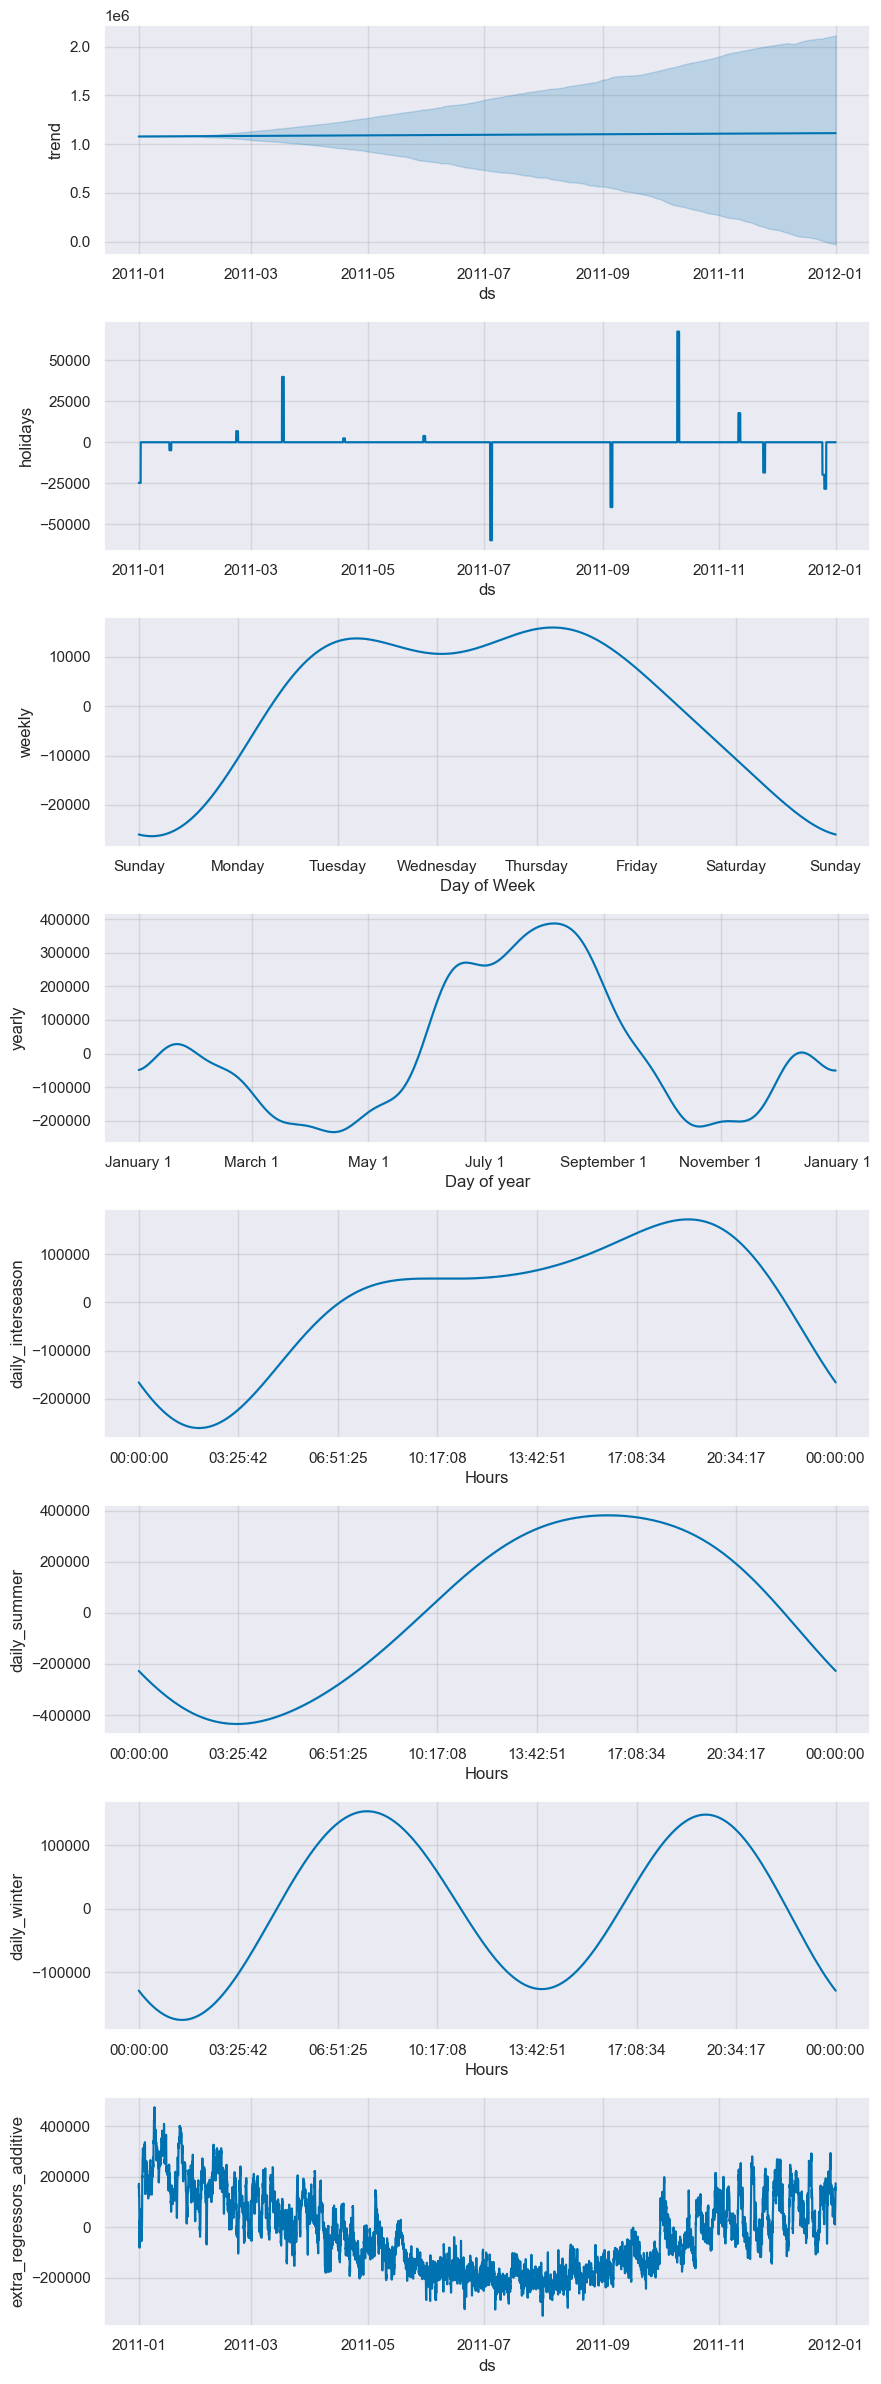

In [20]:
fig = top_model.plot_components(top_model.predict(test_df))

In [18]:
np.sqrt(mean_squared_error(y_pred, y_test))

171943.32393010022

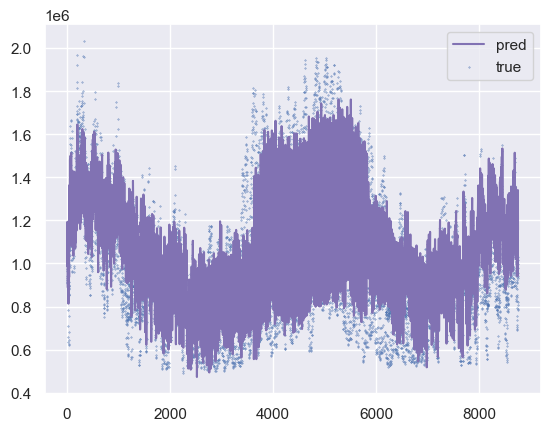

In [16]:
plt.plot(list(range(len(y_pred))), y_pred, label="pred", c="C4")
plt.scatter(list(range(len(y_pred))), y_test, label="true", s=0.1)
plt.legend()
plt.show()

In [ ]:
reconcilers = [MinTrace(method="ols"), MinTrace(method="wls_struct"), MinTrace(method="wls_var"), MinTrace(method="mint_shrink"), MinTrace(method="mint_cov"),  BottomUp(), TopDown(method="forecast_proportions")]
hrec = HierarchicalReconciliation(reconcilers=reconcilers)
y_hat_rec = hrec.reconcile(y_hat_df, S, tags, Y_train)

In [ ]:
evaluator = HierarchicalEvaluation(evaluators=[rmse, mean_absolute_error])
evaluator.evaluate(Y_hat_df = y_hat_rec, Y_test_df = Y_test,
                   tags=tags)